# Combined algorithm simulation
Computes stage-wide SINRs for the complete processing pipeline, including the ability to add:
- Echoes and noise
- More than 2 sources
- Source movement

In [27]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import colormaps
import pyroomacoustics as pra
from pyroomacoustics.directivities import (
    DirectivityPattern,
    DirectionVector,
    CardioidFamily,
)
from scipy.io import wavfile
from playsound import playsound
from scipy.signal import resample

Simulation parameters

In [28]:
# ROOM PARAMETERS
fs = 8000 # audio sampling frequency - global (set to freq of input file)

room_x = 10 # room width
room_y = 20 # room length
stage_x = [1, 9]
stage_y = [13, 17] # x/y bounds of stage in the room
order = 0 # reflection order
sigma2_n = 5e-7 # microphone noise variance estimate
v_sound = 343.0 # speed of sound in air
source_step = 0.1 # resolution of simulation grid (m)

m = pra.make_materials(
    ceiling="hard_surface",
    floor="stage_floor",
    east="brickwork",
    west="brickwork",
    north="brickwork",
    south="brickwork",
) # materials of each surface of room, defines signal absorption when order is nonzero

# MIC ARRAY PARAMETERS
pattern = pra.DirectivityPattern.CARDIOID
orientation = pra.DirectionVector(azimuth=90, colatitude=None, degrees=True)
directivity = pra.CardioidFamily(orientation=orientation, pattern_enum=pattern)

dist_to_stage = 0.5 # design parameter for array y location
array_loc = [5, stage_y[0]-dist_to_stage] # x/y location of array - front and center of stage
n_mics = 8 # number of microphones

N = 1024 # fft length - defines N/2 + 1 frequency bands

# SOUND SOURCE PARAMETERS
source_x = np.arange(stage_x[0], stage_x[1]+source_step, source_step)
source_y = np.arange(stage_y[0], stage_y[1]+source_step, source_step) # Define spatial grid over which to simulate
source_filenames = ['../input_samples/singing_8000.wav', '../input_samples/german_speech_8000.wav']
_, singing = wavfile.read(source_filenames[0])
_, speech = wavfile.read(source_filenames[1])

### Effect of Noise

Test different noise magnitudes

Noise of 5e-08 ...
Noise magnitude:  5e-08
Average SINR across stage (dB):  105.12133856903505
Maximum SINR across stage (dB):  109.36120475975956
Minimum SINR across stage (dB):  102.71427851470045
Noise of 5e-07 ...
Noise magnitude:  5e-07
Average SINR across stage (dB):  85.12703281154724
Maximum SINR across stage (dB):  89.37450113668812
Minimum SINR across stage (dB):  82.71686743690078
Noise of 5e-06 ...
Noise magnitude:  5e-06
Average SINR across stage (dB):  65.17600794000438
Maximum SINR across stage (dB):  69.4661963726456
Minimum SINR across stage (dB):  62.74249952735761
Noise of 5e-05 ...
Noise magnitude:  5e-05
Average SINR across stage (dB):  45.52433446328144
Maximum SINR across stage (dB):  49.91804742213208
Minimum SINR across stage (dB):  42.982974947067845
Noise of 0.0005 ...
Noise magnitude:  0.0005
Average SINR across stage (dB):  27.779942529311338
Maximum SINR across stage (dB):  32.27082054822031
Minimum SINR across stage (dB):  24.921938044930503
Noise of 0.00

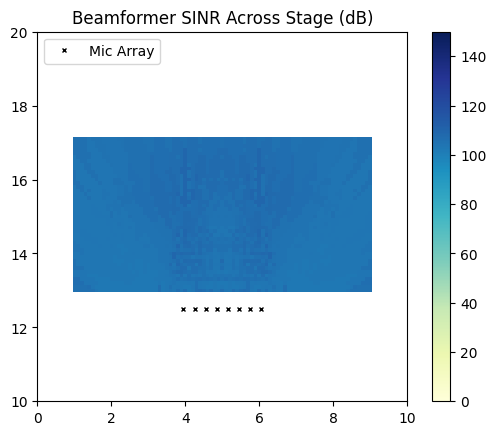

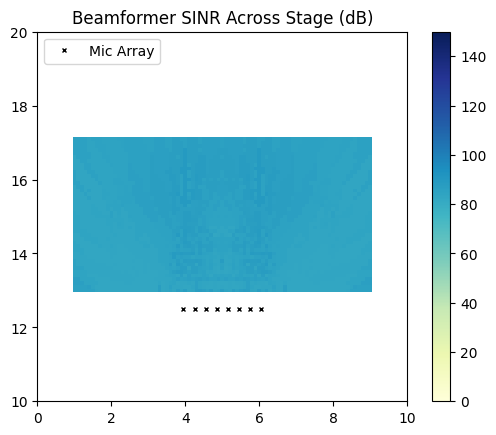

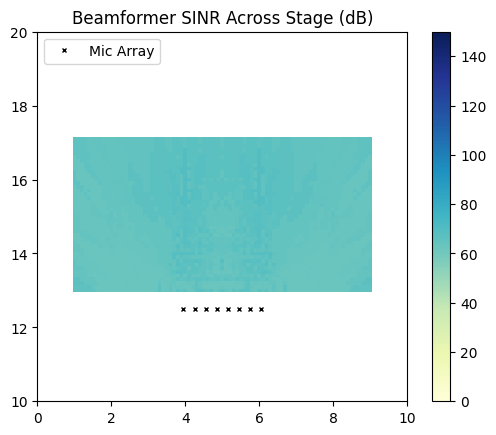

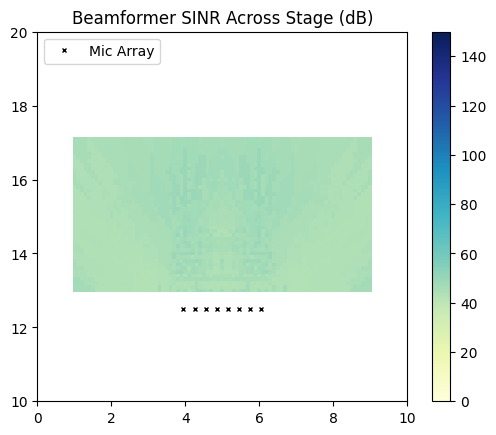

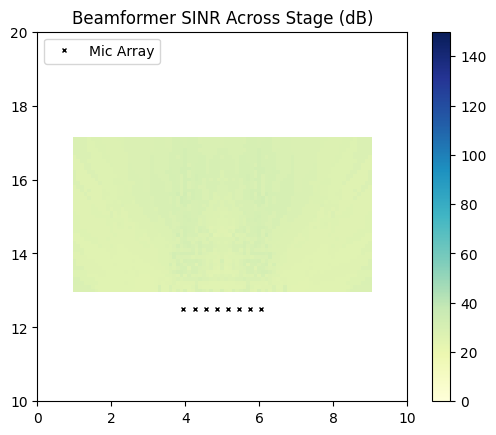

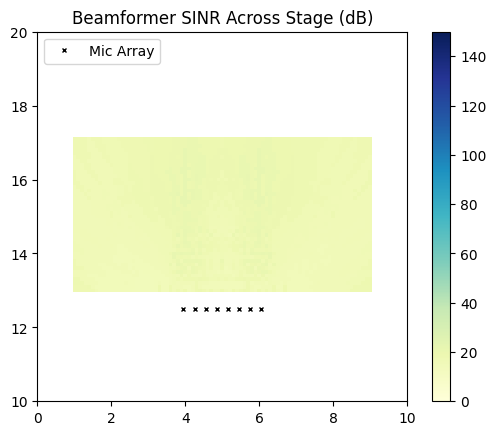

In [29]:
sep = 0.3 # microphone spacing from geometry design
d = 2 # source separation parameter
sigmas = [5e-8, 5e-7, 5e-6, 5e-5, 5e-4, 5e-3] # varying noise magnitudes
guess_dist = 5 # guessed distance away from array - choose far distance for precise beam

for n in sigmas:
    R = pra.linear_2D_array(center=array_loc, M=n_mics, phi=0, d=sep)
    mic_array = pra.Beamformer(R, fs, N) # uses omnidirectional mics by default
    mic_array.set_directivity(directivities=directivity) # use cardioid microphones

    SIRs = np.empty(shape=(len(source_x),len(source_y)))
    print(f'Noise of {n} ...')

    for i in range(len(source_x)):
        for j in range(len(source_y)):

            x = source_x[i]
            y = source_y[j]

            # build room, array, and sources
            room = pra.ShoeBox([room_x, room_y], fs=fs, materials=m, max_order=0, air_absorption=True, ray_tracing=False)
            room.add_microphone_array(mic_array)

            s1 = [x, y] # 1st source location
            s1_mic = [x - array_loc[0], y - array_loc[1]] # location relative to array
            r = math.sqrt(s1_mic[0]**2 + s1_mic[1]**2)

            if r >= d:
                phi_rad = 2 * math.asin(d/(2*r))

                if s1_mic[0] < 0:
                    phi_rad *= -1

                s2_mic = [s1_mic[0]*math.cos(phi_rad) - s1_mic[1]*math.sin(phi_rad), s1_mic[0]*math.sin(phi_rad) + s1_mic[1]*math.cos(phi_rad)] # 2nd source location relative to array
                s2 = [s2_mic[0] + array_loc[0], s2_mic[1] + array_loc[1]]
            else:
                if s1_mic[0] < 0:
                    multiplier = 1
                else:
                    multiplier = -1

                s2 = [s1[0] + multiplier*d, s1[1]]

            source_locs = [s1, s2] # locations of each source
            room.add_source(source_locs[0], signal=singing, delay=0)
            room.add_source(source_locs[1], signal=speech, delay=0)

            # run simulation
            room.compute_rir()
            room.simulate()

            # short-time fourier transform of signal
            X = np.array(
                [
                    pra.transform.stft.analysis(signal, N, N // 2).T
                    for signal in room.mic_array.signals
                ]
            )

            # NormMUSIC algorithm selected, recommended over MUSIC
            n_source = 2
            doa = pra.doa.normmusic.NormMUSIC(R, fs, N, c=v_sound, num_src=n_source, mode='far', azimuth=np.linspace(0, 180, 30)*np.pi/180)
            doa.locate_sources(X, freq_bins=np.arange(1, N))
            doa_azimuths = doa.azimuth_recon
            doa_azimuths.sort()
            a1_gt = math.atan2(s1[1] - array_loc[1], s1[0] - array_loc[0])
            a2_gt = math.atan2(s2[1] - array_loc[1], s2[0] - array_loc[0])

            # add guessed locations of sources to room
            guess_source_locs = np.empty((2, n_source))
            for k in range(n_source):
                guess_source_locs[0, k] = array_loc[0] + guess_dist*np.cos(doa_azimuths[k])
                guess_source_locs[1, k] = array_loc[1] + guess_dist*np.sin(doa_azimuths[k])

            interf = pra.soundsource.SoundSource([0, 0])
            interf.images = guess_source_locs[:, 1]

            source = pra.soundsource.SoundSource([0, 0])
            source.images = guess_source_locs[:, 0]

            # define beamformer algorithm and compute weights
            mic_array.rake_max_sinr_weights(
                source=source,
                interferer=interf,
                R_n=n * np.eye(mic_array.M)
            )
            mic_array.filters_from_weights()

            # compute SIR, averaged across all frequency bands
            SIR_sum = 0
            for f in mic_array.frequencies:
                current_SIR = mic_array.snr(source, interf, f, dB=True)
                if math.isnan(current_SIR) == False:
                    SIR_sum += current_SIR
            SIRs[i, j] = SIR_sum / len(mic_array.frequencies)

    # # save processed sound as output
    # output = mic_array.process(FD=False)
    # out_norm = pra.normalize(output)
    # wavfile.write('processed_noise_' + str(n) + '.wav', fs, out_norm)

    # # save sound from middle mic as an estimated raw input
    # raw_mic = pra.normalize(mic_array.signals[mic_array.M // 2])
    # wavfile.write('raw_noise_' + str(n) + '.wav', fs, raw_mic)

    # plot SIR as a function of location
    y, x = np.meshgrid(source_y, source_x)
    sir_min = np.min(SIRs)
    sir_max = np.max(SIRs)
    sir_avg = np.mean(SIRs)

    fig, ax = plt.subplots()
    c = ax.pcolormesh(x, y, SIRs, cmap='YlGnBu', vmin=0, vmax=150)
    ax.plot(mic_array.R[0], mic_array.R[1], 'kx', markersize=3, label="Mic Array")
    ax.set_title('Beamformer SINR Across Stage (dB)')
    ax.axis([0, room_x, room_y/2, room_y])
    fig.gca().set_aspect('equal', adjustable='box')
    fig.colorbar(c, ax=ax)
    plt.legend(loc="upper left")
    plt.savefig('noise_' + str(n) + '.png')

    # output SIR stats
    print("Noise magnitude: ", n)
    print("Average SINR across stage (dB): ", sir_avg)
    print("Maximum SINR across stage (dB): ", sir_max)
    print("Minimum SINR across stage (dB): ", sir_min)

### Three-source problem

Three, side-by-side vocal sources, separated by 2m each

In [1]:
room = pra.ShoeBox([room_x, room_y], fs=fs, materials=m, max_order=0, air_absorption=True, ray_tracing=False)
R = pra.linear_2D_array(center=array_loc, M=n_mics, phi=0, d=sep)
mic_array = pra.Beamformer(R, room.fs, N)
mic_array.set_directivity(directivities=directivity) # use cardioid microphones
room.add_microphone_array(mic_array)

source_locs = [[3, 15], [5, 15], [7, 15]] # locations of each source in 3D space (can modify)
source_inputs = ['../input_samples/singing_8000.wav', '../input_samples/german_speech_8000.wav', '../input_samples/cmu_arctic_us_aew_a0001.wav'] # filepaths to wav files being played by the source
azimuths = []

for i in range(len(source_locs)):
    rate, audio = wavfile.read(source_inputs[i])

    # ensure sampling rates of all audio matches
    if rate != fs:
        num_samples = int(len(audio) * fs / rate)
        audio = resample(audio, num_samples)
    room.add_source(source_locs[i], signal=audio, delay=0)

    # ground truth azimuths (calculated relative to the x axis)
    azimuths.append(180/np.pi * math.atan2(source_locs[i][1] - array_loc[1], source_locs[i][0] - array_loc[0]))
    
azimuths.sort()
print('Source azimuths:', azimuths)

# DOA estimation
room.compute_rir()
room.simulate()

# short-time fourier transform of signal
X = np.array(
    [
        pra.transform.stft.analysis(signal, N, N // 2).T
        for signal in room.mic_array.signals
    ]
)

# NormMUSIC algorithm selected, recommended over MUSIC
n_source = 3
doa = pra.doa.normmusic.NormMUSIC(R, fs, N, c=v_sound, num_src=n_source, mode='far', azimuth=np.linspace(0, 180, 30)*np.pi/180)
doa.locate_sources(X, freq_bins=np.arange(1, N))
doa_azimuths = doa.azimuth_recon
doa_azimuths.sort()
azimuth_errors = [azimuths[i] - doa_azimuths[i] * 180.0/np.pi for i in range(len(azimuths))]

print("Recovered azimuths:", doa_azimuths * 180.0/np.pi, "degrees")
print("Angular Errors:", azimuth_errors, "degrees")

# add guessed locations of sources to room
guess_dist = 5 # guessed distance away from array - choose far distance for precise beam
guess_source_locs = np.empty((2, n_source))

for i in range(n_source):
    guess_source_locs[0, i] = array_loc[0] + guess_dist*np.cos(doa_azimuths[i])
    guess_source_locs[1, i] = array_loc[1] + guess_dist*np.sin(doa_azimuths[i])

# Beamforming algorithm for each source
for i in range(guess_source_locs.shape[1]):
    current_interferers = guess_source_locs
    current_interferers = np.delete(current_interferers, i, 1)

    interf = pra.soundsource.SoundSource([0, 0])
    interf.images = current_interferers

    source = pra.soundsource.SoundSource([0, 0])
    source.images = np.array([[guess_source_locs[0, i]], [guess_source_locs[1, i]]])

    mic_array.rake_max_sinr_weights(
        source=source,
        interferer=interf,
        R_n=sigma2_n * np.eye(mic_array.M) # estimated noise covariance matrix
    )
    mic_array.filters_from_weights() # process with time domain filters for now, can also use FD directly

    # compute SIR, averaged across all frequency bands
    SIR_sum = 0
    for f in mic_array.frequencies:
        current_SIR = mic_array.snr(source, interf, f, dB=True)
        if math.isnan(current_SIR) == False:
            SIR_sum += current_SIR
            # print(f'frequency band: {f:.2f}, SINR: {current_SIR:.2f}')
    SIR_avg = SIR_sum / len(mic_array.frequencies)
    print(f'source {i+1}: average SINR: {SIR_avg:.2f}')
    room.plot(freq=[200, 500, 1000], plot_directivity=False)

NameError: name 'pra' is not defined